# Imports

In [112]:
import math
import os
import torch
from pyro.infer.autoguide.initialization import init_to_value
import torch.distributions.constraints as constraints
import pyro
from pyro import poutine
import pickle
import numpy as np
import copy
import time
import snakeviz
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import random
from sklearn.datasets import load_diabetes
assert pyro.__version__.startswith('1.8.4')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Load Datasets

### Random Dataset

In [113]:
def generate_stdp_dataset(dim, num_examples, min_value, max_value):
    X = np.random.random((num_examples + 1, dim)) * (max_value - min_value) + min_value
    beta = np.random.random((dim)) * (max_value - min_value) + min_value

    noise = np.random.normal(0, np.sqrt(max_value - min_value), num_examples + 1)
    Y = X[:num_examples + 1] @ beta + noise

    X = np.asfortranarray(X)
    Y = np.asfortranarray(Y)
    X /= np.linalg.norm(X, axis=0)
    Y = (Y - Y.mean()) / Y.std()
    Y = Y * max_value

    Y = Y/np.linalg.norm(Y)

    return X, Y, beta

In [114]:
X, Y, beta = generate_stdp_dataset(10, 442, 0, 1)

### Diabetes Dataset

X, Y = load_diabetes(return_X_y = True)

print(Y[0:3])
Y = (Y - Y.mean()) / Y.std()
print(Y[0:3])
X = X / np.linalg.norm(X)
print(X[0:3])

### Set up X, Y train

In [115]:
X_train = copy.deepcopy(X)
Y_train = copy.deepcopy(Y[:len(Y) - 1])
X_train = [torch.tensor(member) for member in X_train]
Y_train = [torch.tensor(member) for member in Y_train]
last_y = Y[-1]
dim = len(X[0])

### Load dataset from pre-generated folder

In [116]:
with open('data/generated_stdp_data/dataset_0.pkl', 'rb') as infile:
    variables = pickle.load(infile)
    X_train = variables['x_train']
    Y_train = variables['y_train']
    last_y = variables['last_y']
    dim = variables['dim']

In [117]:
print(Y_train)

[tensor(-0.0396, dtype=torch.float64), tensor(0.0560, dtype=torch.float64), tensor(0.0254, dtype=torch.float64), tensor(-0.0548, dtype=torch.float64), tensor(0.0105, dtype=torch.float64), tensor(-0.0536, dtype=torch.float64), tensor(0.0930, dtype=torch.float64), tensor(0.1202, dtype=torch.float64), tensor(0.0638, dtype=torch.float64), tensor(-0.0368, dtype=torch.float64), tensor(-0.1037, dtype=torch.float64), tensor(0.0125, dtype=torch.float64), tensor(-2.7243e-05, dtype=torch.float64), tensor(0.0224, dtype=torch.float64), tensor(0.0337, dtype=torch.float64), tensor(-0.0851, dtype=torch.float64), tensor(0.0305, dtype=torch.float64), tensor(-0.0274, dtype=torch.float64), tensor(0.0310, dtype=torch.float64), tensor(-0.0121, dtype=torch.float64), tensor(0.0402, dtype=torch.float64), tensor(0.0625, dtype=torch.float64), tensor(0.0798, dtype=torch.float64), tensor(-0.0841, dtype=torch.float64), tensor(-0.0498, dtype=torch.float64), tensor(0.0431, dtype=torch.float64), tensor(-0.0310, dtype=

# Model and Guide Setup

In [118]:
def is_converged(arr):
    if len(arr) < 2:
        return False
    # check if last values have changed by 1% or less
    return (max(arr) - min(arr)) / max(arr) < 0.01

In [119]:
is_converged([3, 3.01])

True

Warm starting can be done by replacing anything that's a hard coded value:
- mu0: torch.zeros
- b: torch.ones
- beta: mu (torch.zeroes), 0
- std: the 1 in dist.HalfNormal(1)

In [120]:
def model(data):
    # define the hyperparameters that control the Beta prior
    mu0 = torch.zeros(dim, dtype=torch.float64)
    bmean = torch.ones(dim, dtype=torch.float64)
    bscale = torch.ones(dim, dtype=torch.float64)
    
    std0 = torch.zeros(dim, dtype=torch.float64)
    s_mean = torch.ones(dim, dtype=torch.float64)
    s_scale = torch.ones(dim, dtype=torch.float64)
    
    b = pyro.sample("b", dist.Gamma(bmean, bscale).to_event(1))
    std_scale = pyro.sample("std_scale", dist.Gamma(s_mean, s_scale).to_event(1))
    
    # sample f from the Beta prior
    beta = pyro.sample("beta", dist.Laplace(mu0, b).to_event(1))
    std = pyro.sample("sigma", dist.Laplace(std0, std_scale).to_event(1))
    # data goes list tuple tensor
          
    with pyro.plate("data", len(data), subsample_size=100) as ind:
        data = np.asarray(data)[ind]
        for i in range(len(data)):
            sampler = dist.Normal(beta.dot(data[i][0]).item(), torch.sigmoid(std.dot(data[i][0])).item())
            pyro.sample("obs_{}".format(i), sampler.to_event(0), obs=data[i][1])

# Global guide
guide = pyro.infer.autoguide.AutoLaplaceApproximation(poutine.block(model, expose=['b', 'beta', 'std_scale', 'sigma']))

In [121]:
def train_SVI(D_hat, n_steps, warm_dict = None):    
    losses = []
    # setup the optimizer
    adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    # setup the inference algorithm
    guide = pyro.infer.autoguide.AutoLaplaceApproximation(poutine.block(model, expose=['b', 'beta','std_scale', 'sigma']))
    if warm_dict is not None:
        guide = pyro.infer.autoguide.AutoLaplaceApproximation(poutine.block(model, expose=['b', 'beta', 'std_scale', 'sigma']), init_loc_fn=init_to_value(values=warm_dict))
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    # do gradient steps
    for step in range(n_steps):
        loss = svi.step(D_hat)
        losses.append(loss)
        if is_converged(losses[-1:-6:-1]):
            print(f"Converged on step {step} -- breaking")
            break
        if loss < 1e-5:
            print(f"Early Loss Stopping on step {step}")
            break
    beta = guide(D_hat)['beta']
    print(f"Ended on step {step}")
    return beta, losses

In [122]:
pyro.clear_param_store()

# Run VI on Data 

In [123]:
rank_proportions = []
y_hat = max(Y_train)
y_bottom = min(Y_train)
print(y_hat)
print(y_bottom)
conformal_set = []
decrease_size = 0.01
start = time.time()
print(max(Y_train))
print(min(Y_train))
prev_d_hat = None
all_losses = []
while y_hat >= y_bottom:
    pyro.clear_param_store()
    # Create D_hat
    D_hat = list(zip(X_train[:-1], Y_train))
    D_hat.append((X_train[-1], y_hat))
    
    # Train SVI
    warm_dict = guide(D_hat)
    if warm_dict is not None:
        beta, losses = train_SVI(D_hat, 100, warm_dict)
    else:
        print("Warm dict was none")
        beta, losses = train_SVI(D_hat, 100)
    all_losses.append(losses)
    
    
    # Calculate rank of y_hat
    rank = [(abs(sum(D_hat[i][0] * beta) - D_hat[i][1]).detach().numpy()) for i in range(len(D_hat))]
    y_hat_rank = rank[-1]
    
    # Add to conformal set if in not in bottom 10 percent of probabilities
    current_rank_proportion = np.count_nonzero(y_hat_rank > rank) / len(rank)
    rank_proportions.append(current_rank_proportion)
    if current_rank_proportion < 0.9:
        conformal_set.append(copy.deepcopy(y_hat))
        print(f"{y_hat} Added")
    else:
        print(f"{y_hat} Not added")
    y_hat -= decrease_size
conformal_set = [min(conformal_set), max(conformal_set)]
end = time.time()

tensor(0.1431, dtype=torch.float64)
tensor(-0.1235, dtype=torch.float64)
tensor(0.1431, dtype=torch.float64)
tensor(-0.1235, dtype=torch.float64)
Converged on step 1 -- breaking
Ended on step 1
0.1431430073104885 Not added
Converged on step 1 -- breaking
Ended on step 1
0.1331430073104885 Not added


/var/folders/1s/1mkc4t8137lbs9x8hhg9q8940000gp/T/ipykernel_83271/1291704646.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.asarray(data)[ind]
/var/folders/1s/1mkc4t8137lbs9x8hhg9q8940000gp/T/ipykernel_83271/1291704646.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data)[ind]


Converged on step 1 -- breaking
Ended on step 1
0.12314300731048851 Not added
Converged on step 1 -- breaking
Ended on step 1
0.11314300731048851 Not added
Converged on step 1 -- breaking
Ended on step 1
0.10314300731048852 Not added
Converged on step 1 -- breaking
Ended on step 1
0.09314300731048852 Not added
Converged on step 1 -- breaking
Ended on step 1
0.08314300731048853 Not added
Converged on step 1 -- breaking
Ended on step 1
0.07314300731048853 Not added
Converged on step 1 -- breaking
Ended on step 1
0.06314300731048854 Added
Converged on step 1 -- breaking
Ended on step 1
0.05314300731048854 Added
Converged on step 1 -- breaking
Ended on step 1
0.043143007310488535 Added
Converged on step 1 -- breaking
Ended on step 1
0.03314300731048853 Added
Converged on step 1 -- breaking
Ended on step 1
0.02314300731048853 Added
Converged on step 1 -- breaking
Ended on step 1
0.01314300731048853 Added
Converged on step 1 -- breaking
Ended on step 1
0.0031430073104885305 Added
Converged o

In [124]:
print(f"Conformal Set: [{float(conformal_set[0])}, {float(conformal_set[1])}]")
print(f"Length: {float(conformal_set[1] - conformal_set[0])}")
print(f"Y[-1]: {last_y}")
if last_y >= conformal_set[0] and last_y <= conformal_set[1]:
    print(f"Y[-1] is covered")
else:
    print("Y[-1] is Not covered")
print(f"Elapsed Time: {end - start}")

Conformal Set: [-0.10685699268951146, 0.06314300731048854]
Length: 0.16999999999999998
Y[-1]: -0.05723415645634303
Y[-1] is covered
Elapsed Time: 2.2802929878234863


In [125]:
print(all_losses[0])

[10296.309044589229, 10327.664202095808]


In [126]:
rank_proportions

[0.9954853273137697,
 0.9909706546275395,
 0.9887133182844243,
 0.981941309255079,
 0.9661399548532731,
 0.9480812641083521,
 0.9232505643340858,
 0.9029345372460497,
 0.8645598194130926,
 0.8081264108352144,
 0.7674943566591422,
 0.7020316027088036,
 0.582392776523702,
 0.4672686230248307,
 0.3905191873589165,
 0.2686230248306998,
 0.14672686230248308,
 0.009029345372460496,
 0.12415349887133183,
 0.2799097065462754,
 0.3972911963882618,
 0.5237020316027088,
 0.636568848758465,
 0.7494356659142212,
 0.7968397291196389,
 0.8939051918735892,
 0.927765237020316]

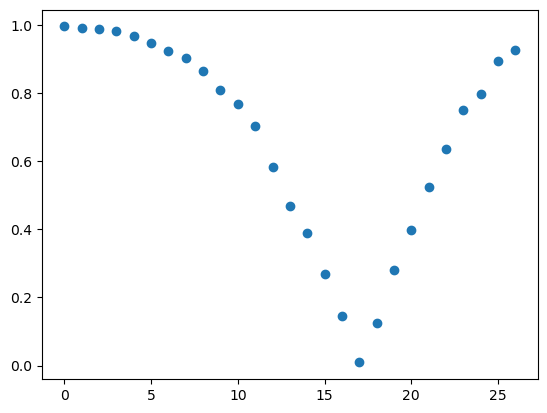

In [127]:
import matplotlib.pyplot as plt
plt.scatter(range(len(rank_proportions)), rank_proportions)
plt.show()

In [128]:
D_hat = list(zip(X_train[:-1], Y_train))
D_hat.append((X_train[-1], y_hat))

In [129]:
print(D_hat[-1])

(tensor([0.0115, 0.0480, 0.0116, 0.0631, 0.0294, 0.0737, 0.0410, 0.0173, 0.0325,
        0.0152], dtype=torch.float64), tensor(-0.1269, dtype=torch.float64))


In [130]:
guide(D_hat)

{'b': tensor([0.7379, 0.7687, 0.8266, 0.4415, 0.8023, 1.0449, 0.4813, 0.8555, 0.8103,
         0.7128], dtype=torch.float64, grad_fn=<ExpandBackward0>),
 'std_scale': tensor([0.4812, 0.6866, 0.2475, 0.3136, 0.4499, 0.4010, 1.0691, 0.4436, 0.4482,
         0.2753], dtype=torch.float64, grad_fn=<ExpandBackward0>),
 'beta': tensor([ 1.9721e-03, -2.9811e-03, -1.4491e-01, -2.2499e-03, -4.2070e-04,
         -1.9887e-01, -6.9351e-04, -2.2144e-01, -1.1297e-03, -1.4179e-04],
        dtype=torch.float64, grad_fn=<ExpandBackward0>),
 'sigma': tensor([ 0.0031,  0.0045,  0.0022, -0.0011,  0.0008,  0.0014, -0.0024, -0.0009,
          0.0045, -0.0014], dtype=torch.float64, grad_fn=<ExpandBackward0>)}

In [131]:
guide

AutoLaplaceApproximation()

In [132]:
guide(D_hat)

{'b': tensor([0.7379, 0.7687, 0.8266, 0.4415, 0.8023, 1.0449, 0.4813, 0.8555, 0.8103,
         0.7128], dtype=torch.float64, grad_fn=<ExpandBackward0>),
 'std_scale': tensor([0.4812, 0.6866, 0.2475, 0.3136, 0.4499, 0.4010, 1.0691, 0.4436, 0.4482,
         0.2753], dtype=torch.float64, grad_fn=<ExpandBackward0>),
 'beta': tensor([ 1.9721e-03, -2.9811e-03, -1.4491e-01, -2.2499e-03, -4.2070e-04,
         -1.9887e-01, -6.9351e-04, -2.2144e-01, -1.1297e-03, -1.4179e-04],
        dtype=torch.float64, grad_fn=<ExpandBackward0>),
 'sigma': tensor([ 0.0031,  0.0045,  0.0022, -0.0011,  0.0008,  0.0014, -0.0024, -0.0009,
          0.0045, -0.0014], dtype=torch.float64, grad_fn=<ExpandBackward0>)}